In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
df = pd.read_parquet("../data/coin-data-hourly.parquet")

In [3]:
df

,Date,Symbol,Open,High,Low,Close,Volume
0,2024-01-19 23:00:00,BTC-USD,41655.851562,41667.484375,41581.902344,41615.031250,0.0
1,2024-01-20 00:00:00,BTC-USD,41624.589844,41640.230469,41446.824219,41480.117188,0.0
2,2024-01-20 01:00:00,BTC-USD,41469.070312,41646.871094,41469.070312,41604.789062,0.0
3,2024-01-20 02:00:00,BTC-USD,41622.125000,41622.125000,41522.097656,41575.363281,0.0
4,2024-01-20 03:00:00,BTC-USD,41589.242188,41624.578125,41512.343750,41624.578125,0.0
...,...,...,...,...,...,...,...
34671,2026-01-17 16:00:00,ETH-USD,3324.941162,3327.528564,3312.172363,3317.843506,98756608.0
34672,2026-01-17 17:00:00,ETH-USD,3317.828369,3325.239014,3316.377441,3317.800781,119856128.0
34673,2026-01-17 18:00:00,ETH-USD,3318.068604,3319.185791,3314.648438,3317.020020,227145728.0
34674,2026-01-17 19:00:00,ETH-USD,3316.825928,3319.273438,3313.659912,3315.241211,100918272.0


In [4]:
df = pd.read_parquet("../data/coin-data-hourly.parquet")


def add_features(df):
    df = df.copy()

    df.sort_values(["Symbol", "Date"], inplace=True)

    def compute_indicators(group):
        group.ta.ema(length=9, append=True)
        group.ta.ema(length=21, append=True)
        group.ta.ema(length=50, append=True)
        group.ta.rsi(length=14, append=True)
        group.ta.macd(fast=12, slow=26, signal=9, append=True)
        group.ta.bbands(length=20, std=2, append=True)
        group.ta.atr(length=14, append=True)
        group.ta.obv(append=True)
        group.ta.log_return(append=True)
        return group

    def rename_columns(group):
        rename_map = {
            "EMA_9": "EMA_SHORT",
            "EMA_21": "EMA_MID",
            "EMA_50": "EMA_LONG",
            "RSI_14": "RSI",
            "ATRr_14": "ATR",
            "OBV": "OBV",
            "LOGRET_1": "LOG_RET",
            "MACD_12_26_9": "MACD_LINE",
            "MACDh_12_26_9": "MACD_HIST",
            "MACDs_12_26_9": "MACD_SIGNAL",
            "BBU_20_2.0_2.0": "BB_UPPER",
            "BBL_20_2.0_2.0": "BB_LOWER",
            "BBM_20_2.0_2.0": "BB_MID",
            "BBP_20_2.0_2.0": "BB_PERCENT",
            "BBB_20_2.0_2.0": "BB_WIDTH",
            "BBU_20_2.0": "BB_UPPER",
            "BBL_20_2.0": "BB_LOWER",
            "BBM_20_2.0": "BB_MID",
        }

        existing_cols = set(group.columns)
        actual_rename_map = {k: v for k, v in rename_map.items() if k in existing_cols}
        group.rename(columns=actual_rename_map, inplace=True)
        return group

    def custom_features(group):
        group["dist_ema_short"] = (group["Close"] - group["EMA_SHORT"]) / group[
            "EMA_SHORT"
        ]
        group["dist_bb_upper"] = (group["Close"] - group["BB_UPPER"]) / group[
            "BB_UPPER"
        ]
        group["signal_rsi_oversold"] = (group["RSI"] < 30).astype(int)
        group["signal_rsi_overbought"] = (group["RSI"] > 70).astype(int)
        group["signal_macd_bullish"] = (group["MACD_HIST"] > 0).astype(int)

        return group

    def add_lags(group):
        cols_to_lag = ["LOG_RET", "RSI", "MACD_HIST"]
        for col in cols_to_lag:
            if col in group.columns:
                group[f"{col}_lag1"] = group[col].shift(1)
                group[f"{col}_lag2"] = group[col].shift(2)

        return group

    df = df.groupby("Symbol", group_keys=False).apply(compute_indicators)
    df = df.groupby("Symbol", group_keys=False).apply(rename_columns)
    df = df.groupby("Symbol", group_keys=False).apply(custom_features)
    df = df.groupby("Symbol", group_keys=False).apply(add_lags)

    df.dropna(inplace=True)

    return df


df = add_features(df)

# fmt: on

/tmp/ipykernel_97649/1130331525.py:70: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Symbol", group_keys=False).apply(compute_indicators)
/tmp/ipykernel_97649/1130331525.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Symbol", group_keys=False).apply(rename_columns)
/tmp/ipykernel_97649/1130331525.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

In [5]:
df["next_8h_close"] = df.groupby("Symbol")["Close"].shift(-8)

threshold = 0.001

df["Target"] = (df["next_8h_close"] > df["Close"] * (1 + threshold)).astype(int)

df.dropna(subset=["next_8h_close"], inplace=True)
df.drop(columns=["next_8h_close"], inplace=True)

In [6]:
from sklearn.model_selection import train_test_split

df = df.sort_values(by="Date")

drop_cols = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Target",
    "Date",
    "Symbol",
]

X = df.drop(columns=drop_cols, errors="ignore")
y = df["Target"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_test, X_backtest, y_test, y_backtest = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

In [7]:
X_train.columns

Index(['EMA_SHORT', 'EMA_MID', 'EMA_LONG', 'RSI', 'MACD_LINE', 'MACD_HIST',
       'MACD_SIGNAL', 'BB_LOWER', 'BB_MID', 'BB_UPPER', 'BB_WIDTH',
       'BB_PERCENT', 'ATR', 'OBV', 'LOG_RET', 'dist_ema_short',
       'dist_bb_upper', 'signal_rsi_oversold', 'signal_rsi_overbought',
       'signal_macd_bullish', 'LOG_RET_lag1', 'LOG_RET_lag2', 'RSI_lag1',
       'RSI_lag2', 'MACD_HIST_lag1', 'MACD_HIST_lag2'],
      dtype='object')

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score


ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

params = {
    "n_estimators": 300,
    "max_depth": 3,
    "random_state": 42,
    "learning_rate": 0.005,
    "scale_pos_weight": ratio,
}

model = XGBClassifier(**params)
model.fit(X_train, y_train)


probs = model.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<18} {'Precision':<10} {'Recall':<10} {'Trade Amount':<12}")
print("-" * 55)


for threshold in np.linspace(0.5, 0.6, 9):

    preds = (probs > threshold).astype(int)

    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    trade_count = preds.sum()

    print(f"{threshold:<18} {prec:.2f}       {rec:.2f}       {trade_count:<12}")

Threshold          Precision  Recall     Trade Amount
-------------------------------------------------------
0.5                0.47       0.46       1588        
0.5125             0.48       0.33       1119        
0.525              0.47       0.10       328         
0.5375             0.48       0.07       230         
0.55               0.49       0.07       211         
0.5625             0.49       0.06       207         
0.575              0.49       0.06       203         
0.5875             0.51       0.06       173         
0.6                0.55       0.04       129         


In [9]:
import optuna
from sklearn.metrics import precision_score, recall_score, average_precision_score

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)


def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 4),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.01, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float(
            "scale_pos_weight", ratio * 0.8, ratio * 1.2
        ),
        "random_state": 42,
        "n_jobs": -1,
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)[:, 1]
    score = average_precision_score(y_test, probs)

    return score


study = optuna.create_study(direction="maximize")
print("Starting optimization...")
study.optimize(objective, n_trials=50)

print("-" * 55)
print(f"Best PR-AUC Score: {study.best_value:.4f}")
print("Best Params:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")
print("-" * 55)

print("\nValidating Best Model on Thresholds:")
best_model = XGBClassifier(**study.best_trial.params)
best_model.fit(X_train, y_train)
probs = best_model.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<18} {'Precision':<10} {'Recall':<10} {'Trade Amount':<12}")
print("-" * 55)

for threshold in np.linspace(0.5, 0.75, 11):
    preds = (probs > threshold).astype(int)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    trade_count = preds.sum()
    print(f"{threshold:<18.2f} {prec:.2f}       {rec:.2f}       {trade_count:<12}")

/home/umc/Desktop/ML TRAINING/Projects/bist-trading-ai /venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-18 00:23:12,781] A new study created in memory with name: no-name-fe345932-c2bc-45b0-afec-d81c75a3362b


Starting optimization...


[I 2026-01-18 00:23:13,665] Trial 0 finished with value: 0.4779720594867669 and parameters: {'n_estimators': 928, 'max_depth': 2, 'learning_rate': 0.0005865677751035209, 'reg_alpha': 0.21886575580491713, 'reg_lambda': 0.0007117592785411259, 'subsample': 0.668645107900296, 'colsample_bytree': 0.9737431136555166, 'scale_pos_weight': 1.0185377585990123}. Best is trial 0 with value: 0.4779720594867669.
[I 2026-01-18 00:23:14,337] Trial 1 finished with value: 0.4798193974021305 and parameters: {'n_estimators': 544, 'max_depth': 2, 'learning_rate': 0.0038209438788316, 'reg_alpha': 0.0006533471491291363, 'reg_lambda': 0.04640259714795329, 'subsample': 0.8804101909846753, 'colsample_bytree': 0.8695163944408586, 'scale_pos_weight': 1.2558278150555073}. Best is trial 1 with value: 0.4798193974021305.
[I 2026-01-18 00:23:14,762] Trial 2 finished with value: 0.47973327783637776 and parameters: {'n_estimators': 708, 'max_depth': 2, 'learning_rate': 0.003372142699339014, 'reg_alpha': 0.0005162984995

-------------------------------------------------------
Best PR-AUC Score: 0.4917
Best Params:
  n_estimators: 993
  max_depth: 2
  learning_rate: 0.00598705601107252
  reg_alpha: 0.578029916290406
  reg_lambda: 0.0008768105214092473
  subsample: 0.5327799214982972
  colsample_bytree: 0.9401205298722377
  scale_pos_weight: 1.0316088982659926
-------------------------------------------------------

Validating Best Model on Thresholds:
Threshold          Precision  Recall     Trade Amount
-------------------------------------------------------
0.50               0.48       0.47       1565        
0.53               0.50       0.27       866         
0.55               0.55       0.10       286         
0.57               0.57       0.06       182         
0.60               0.61       0.03       88          
0.62               0.59       0.01       39          
0.65               0.50       0.00       14          
0.68               0.42       0.00       12          
0.70               0

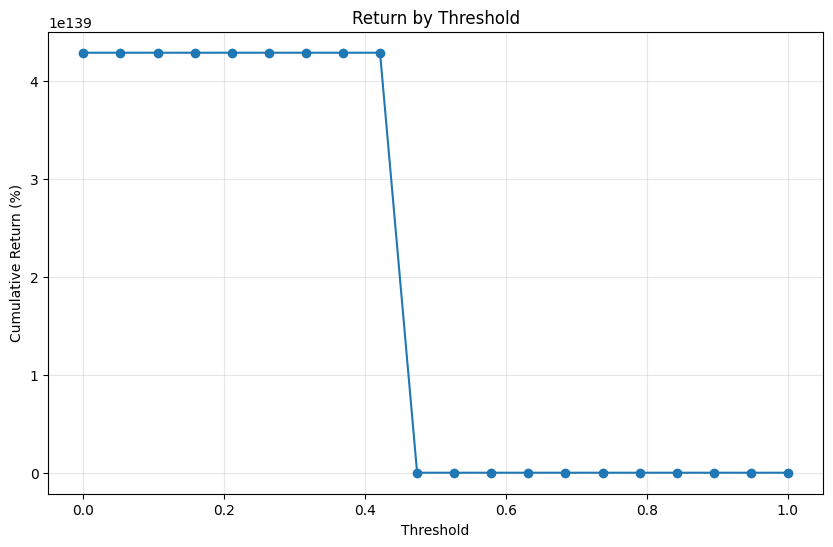

In [36]:
analysis = pd.DataFrame(
    {
        "Symbol": df.loc[X_backtest.index, "Symbol"],
        "Open": df.loc[X_backtest.index, "Open"],
        "Low": df.loc[X_backtest.index, "Low"],
        "High": df.loc[X_backtest.index, "High"],
        "Close": df.loc[X_backtest.index, "Close"],
        "Prob": probs,
        "Date": df.loc[X_backtest.index, "Date"],
    }
)

analysis = analysis.sort_values("Date").reset_index(drop=True)

returns = []
thresholds = np.linspace(0, 1, 20)

for threshold in thresholds:

    TAKE_PROFIT = 0.02
    STOP_LOSS = 0.01
    COMMISSION = 0.001
    INITIAL_CAPITAL = 10000.0
    HOLD_PERIOD = 8

    analysis["Signal"] = (analysis["Prob"] > threshold).astype(int)

    current_capital = INITIAL_CAPITAL
    in_trade = False
    entry_price = 0.0
    exit_step_limit = 0

    signals = analysis["Signal"].shift(1).fillna(0)

    for i in range(len(analysis)):
        row = analysis.iloc[i]

        current_open = row["Open"]
        current_low = row["Low"]
        current_high = row["High"]
        current_close = row["Close"]

        if in_trade:

            sl_price = entry_price * (1 - STOP_LOSS)
            hit_sl = current_low <= sl_price

            tp_price = entry_price * (1 + TAKE_PROFIT)
            hit_tp = current_high >= tp_price

            time_exit = i >= exit_step_limit

            exit_price = 0.0
            execute_exit = False

            if hit_sl:
                exit_price = (
                    min(current_open, sl_price) if current_open < sl_price else sl_price
                )

                execute_exit = True

            elif hit_tp:
                exit_price = (
                    max(current_open, tp_price) if current_open > tp_price else tp_price
                )

                execute_exit = True

            elif time_exit:
                exit_price = current_close
                execute_exit = True

            if execute_exit:
                raw_return = (exit_price - entry_price) / entry_price
                current_capital = current_capital * (1 + raw_return - COMMISSION)
                in_trade = False

        elif not in_trade:
            if signals[i] == 1:
                in_trade = True
                entry_price = current_open
                exit_step_limit = i + HOLD_PERIOD

    total_return = (current_capital - INITIAL_CAPITAL) / INITIAL_CAPITAL
    returns.append(total_return)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, returns, marker="o")
plt.title("Return by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Cumulative Return (%)")
plt.grid(True, alpha=0.3)

In [37]:
analysis

,Symbol,Open,Low,High,Close,Prob,Date,Signal
0,ETH-USD,3829.650635,3827.897461,3856.018799,3844.226562,0.519278,2025-10-31 01:00:00,0
1,BTC-USD,109594.359375,108690.320312,109641.195312,108804.484375,0.535598,2025-10-31 02:00:00,0
2,ETH-USD,3846.122559,3811.953369,3849.025635,3819.152100,0.519278,2025-10-31 02:00:00,0
3,BTC-USD,108831.820312,108667.062500,109263.820312,109224.187500,0.535598,2025-10-31 03:00:00,0
4,ETH-USD,3820.614502,3813.400879,3833.941162,3826.723877,0.519278,2025-10-31 03:00:00,0
...,...,...,...,...,...,...,...,...
3452,BTC-USD,95211.289062,95064.843750,95219.226562,95077.945312,0.469174,2026-01-17 10:00:00,0
3453,ETH-USD,3294.829102,3292.790771,3302.272705,3301.244873,0.502605,2026-01-17 11:00:00,0
3454,BTC-USD,95066.109375,95029.234375,95268.000000,95255.242188,0.471305,2026-01-17 11:00:00,0
3455,BTC-USD,95267.835938,95199.992188,95312.906250,95205.414062,0.471305,2026-01-17 12:00:00,0
